# Toy Experiments

## 1. Imports

In [1]:
import os, sys
sys.path.append("..")

from src import distributions

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

import numpy as np
import math
import pdb

from sklearn.datasets import make_blobs, make_swiss_roll
from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
torch.set_num_threads(2)

## 2. Used functions

In [2]:
def make_net(n_inputs, n_outputs, n_layers=3, n_hiddens=100):
    layers = [nn.Linear(n_inputs, n_hiddens), nn.ReLU()]
    
    for i in range(n_layers - 1):
        layers.extend([nn.Linear(n_hiddens, n_hiddens), nn.ReLU()])
        
    layers.append(nn.Linear(n_hiddens, n_outputs))
    
    return nn.Sequential(*layers)


class SDE(nn.Module):
    def __init__(self, shift_model, epsilon, n_steps):
        super().__init__()
        self.shift_model = shift_model
        self.noise_std = math.sqrt(epsilon)
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
    
    def forward(self, x0):
        t0 = 0
        trajectory = [x0]
        times = [t0]
        shifts = []
        
        x, t = x0, t0
        
        for step in range(self.n_steps):
            x, t, shift = self._step(x, t)
            
            trajectory.append(x)
            times.append(t)
            shifts.append(shift)
        
        return torch.stack(trajectory, dim=1), torch.tensor(times), torch.stack(shifts, dim=1)
        
    def _step(self, x, t):
        shift = self._get_shift(x, t)
        noise = self._sample_noise(x)
        
        return x + self.delta_t*shift + noise, t + self.delta_t, shift
    
    def _get_shift(self, x, t):
        batch_size = x.shape[0]
        t = torch.tensor(t).repeat(batch_size)
        
        inp = torch.cat((x, t[:, None]), dim =-1)
        return self.shift_model(inp)
        
    def _sample_noise(self, x):
        return self.noise_std*math.sqrt(self.delta_t)*(torch.randn(x.shape))
    
    def set_n_steps(self, n_steps):
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
        

def integrate(values, times):
    deltas = (times[1:] - times[:-1])
    return (values*deltas[None, :]).sum(dim = 1)
    

def train(X_sampler, Y_sampler,
          sde, sde_opt,
          beta_net, beta_net_opt,
          epsilon, iterations, 
          inner_iterations, plot_n_samples=500):
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    norms = []
    
    integral_scale = 1
    max_norm = 1
    
    for iteration in tqdm(range(iterations)):
        x0, x1 = X_sampler.sample(), Y_sampler.sample()
        
        trajectory, times, shifts = sde(x0)
        xN = trajectory[:, -1, :]
        
        norm = torch.norm(shifts, p=2, dim=-1)**2
        
        if iteration % 100 == 0:
            clear_output(wait=True)
            
            transfered_dataset = map_dataset(sde, X_sampler, batch_size, plot_n_samples)
            
            original_dataset = torch.cat(
                [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            
            plot_results(original_dataset, target_dataset, transfered_dataset)
            plt.show()
        
        integral = integral_scale*integrate(norm, times)
        
        loss_beta = (-integral - beta_net(x1) + beta_net(xN)).mean()
        beta_net_opt.zero_grad()
        loss_beta.backward()
        beta_net_opt.step()
        
        for inner_iteration in range(inner_iterations):
            x0, x1 = X_sampler.sample(), Y_sampler.sample()
            x0, x1 = x0.to(device), x1.to(device)

            trajectory, times, shifts = sde(x0)
            xN = trajectory[:, -1, :]

            norm = torch.norm(shifts, p=2, dim=-1)**2
            integral = integral_scale*integrate(norm, times)
            
            loss_sde = (integral + beta_net(x1) - beta_net(xN)).mean()
            sde_opt.zero_grad()
            loss_sde.backward()
            sde_opt.step()
            
    return sde, beta_net, norms


@torch.no_grad()
def map_dataset(sde, sampler, batch_size=32, plot_n_samples=500):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    mapped_data = []
    for i in range(plot_n_samples//batch_size + 1):
        x0 = X_sampler.sample(batch_size)
        trajectory, times, _ = sde(x0)
        xN = trajectory[:, -1, :]

        mapped_data.append(xN.cpu())

    mapped_data = torch.cat(mapped_data)[:plot_n_samples]
    
    return mapped_data


def plot_results(original_dataset, target_dataset, transfered_dataset):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].scatter(
        original_dataset.numpy()[:, 0], original_dataset.numpy()[:, 1],
        c="g", s=32, edgecolors="black"
    )
    axes[0].set_title("Input distribution")

    axes[1].scatter(
        target_dataset.numpy()[:, 0], target_dataset.numpy()[:, 1],
        c="orange", s=32, edgecolors="black"
    )
    axes[1].set_title("Target distribution")

    axes[2].scatter(
        transfered_dataset.numpy()[:, 0], transfered_dataset.numpy()[:, 1],
        c="yellow", s=32, edgecolors="black"
    )
    axes[2].set_title("Fitted distribution")
    
    for i in range(3):
        axes[i].grid()
        axes[i].set_xlim([-2.5, 2.5])
        axes[i].set_ylim([-2.5, 2.5])
    
    plt.plot()

### 3. Config

target_data_type is "8_gaussians" or "swiss_roll" depending on the target distribution

In [3]:
DEVICE_IDS = [3]
SEED = 0xBADBEEF

torch.manual_seed(SEED); np.random.seed(SEED)

batch_size = 512
iterations = 20000
inner_iterations = 10
epsilon = 0.1
lr = 1e-4
n_steps = 10

# "8_gaussians" or "swiss_roll"
target_data_type = "swiss_roll"

## 4. Training

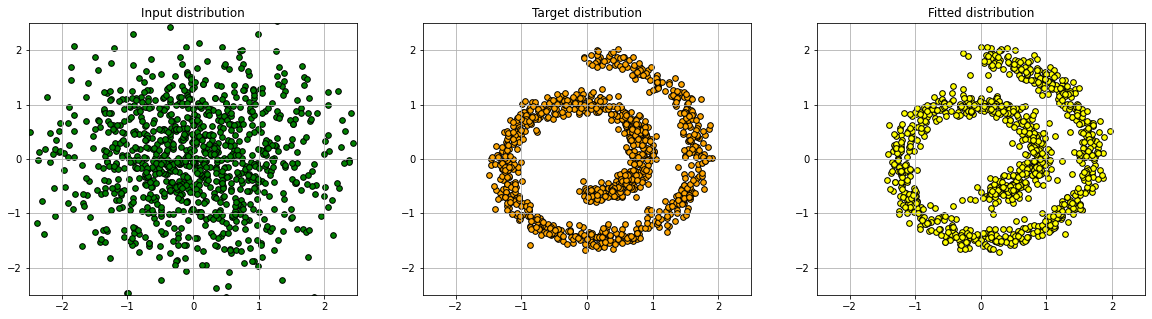

100%|██████████| 20000/20000 [38:46<00:00,  8.60it/s]


In [60]:
X_sampler = distributions.StandardNormalSampler(dim=2, device="cpu")

if target_data_type == "swiss_roll":
    Y_sampler = distributions.SwissRollSampler(device="cpu")
elif target_data_type == "8_gaussians":
    Y_sampler = distributions.Mix8GaussiansSampler(std=0.1, r=math.sqrt(2), device="cpu")

sde_shift_model = make_net(n_inputs=2+1, n_outputs=2, n_layers=3, n_hiddens=100)
sde = SDE(shift_model=sde_shift_model, epsilon=epsilon, n_steps=n_steps)

beta_net = make_net(n_inputs=2, n_outputs=1, n_layers=3, n_hiddens=100)

sde_opt = Adam(sde.parameters(), lr=lr)
beta_net_opt = Adam(beta_net.parameters(), lr=lr)

sde, beta_net, norms = train(X_sampler, Y_sampler,
                      sde, sde_opt,
                      beta_net, beta_net_opt,
                      epsilon, iterations,
                      inner_iterations, plot_n_samples=1000)

### Current model plots

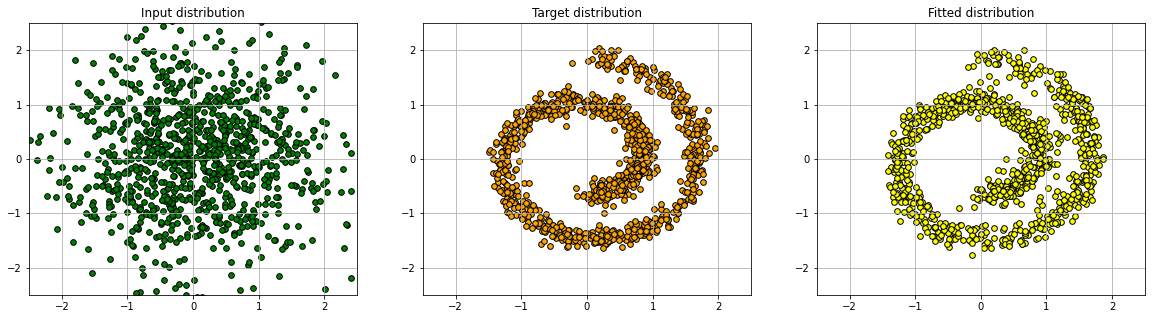

In [61]:
plot_n_samples = 1000

transfered_dataset = map_dataset(sde, X_sampler, batch_size, plot_n_samples)
original_dataset = torch.cat(
    [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
    dim=0,
)[:plot_n_samples].cpu()
target_dataset = torch.cat(
    [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
    dim=0,
)[:plot_n_samples].cpu()

plot_results(original_dataset, target_dataset, transfered_dataset)
plt.show()

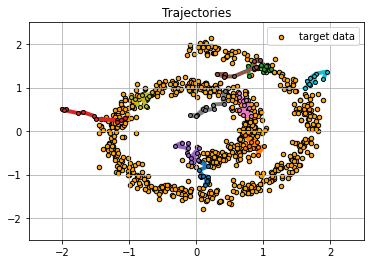

In [62]:
tr = sde(X_sampler.sample(64)[:64])[0].detach().cpu()

for i in range(10):
    plt.plot(tr[i, :, 0], tr[i, :, 1], "-o", markeredgecolor="black", linewidth=4, markersize=4)

target_dataset =  Y_sampler.sample(750).cpu().numpy()
plt.scatter(
    target_dataset[:, 0], target_dataset[:, 1],
    c="orange", s=20, edgecolors="black", label="target data"
)
plt.title("Trajectories")

plt.grid()
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.legend()

plt.show()

### Saving model

In [64]:
path = "../toy_sde_models/"
torch.save(sde.state_dict(), os.path.join(path, f'sde_{target_data_type}_{epsilon}_{n_steps}.pt'))

## 5. Final plots for all models

### Models loading

In [4]:
epsilons = [0, 0.01, 0.1]
path = "../toy_sde_models/"

X_sampler = distributions.StandardNormalSampler(dim=2, device="cpu")

if target_data_type == "swiss_roll":
    Y_sampler = distributions.SwissRollSampler(device="cpu")
elif target_data_type == "8_gaussians":
    Y_sampler = distributions.Mix8GaussiansSampler(std=0.1, r=math.sqrt(2), device="cpu")

sdes = []
for epsilon in epsilons:
    sde_shift_model = make_net(n_inputs=2+1, n_outputs=2, n_layers=3, n_hiddens=100)
    sde = SDE(shift_model=sde_shift_model, epsilon=epsilon, n_steps=n_steps)
    sde.load_state_dict(torch.load(os.path.join(path, f'sde_{target_data_type}_{epsilon}_{n_steps}.pt')))
    print(os.path.join(path, f'sde_{target_data_type}_{epsilon}_{n_steps}.pt'))
    sdes.append(sde)

../toy_sde_models/sde_swiss_roll_0_10.pt
../toy_sde_models/sde_swiss_roll_0.01_10.pt
../toy_sde_models/sde_swiss_roll_0.1_10.pt


In [5]:
plot_n_samples=600

original_dataset = torch.cat(
    [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
    dim=0,
)[:plot_n_samples].cpu()
target_dataset = torch.cat(
    [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
    dim=0,
)[:plot_n_samples].cpu()

### Plot for all models

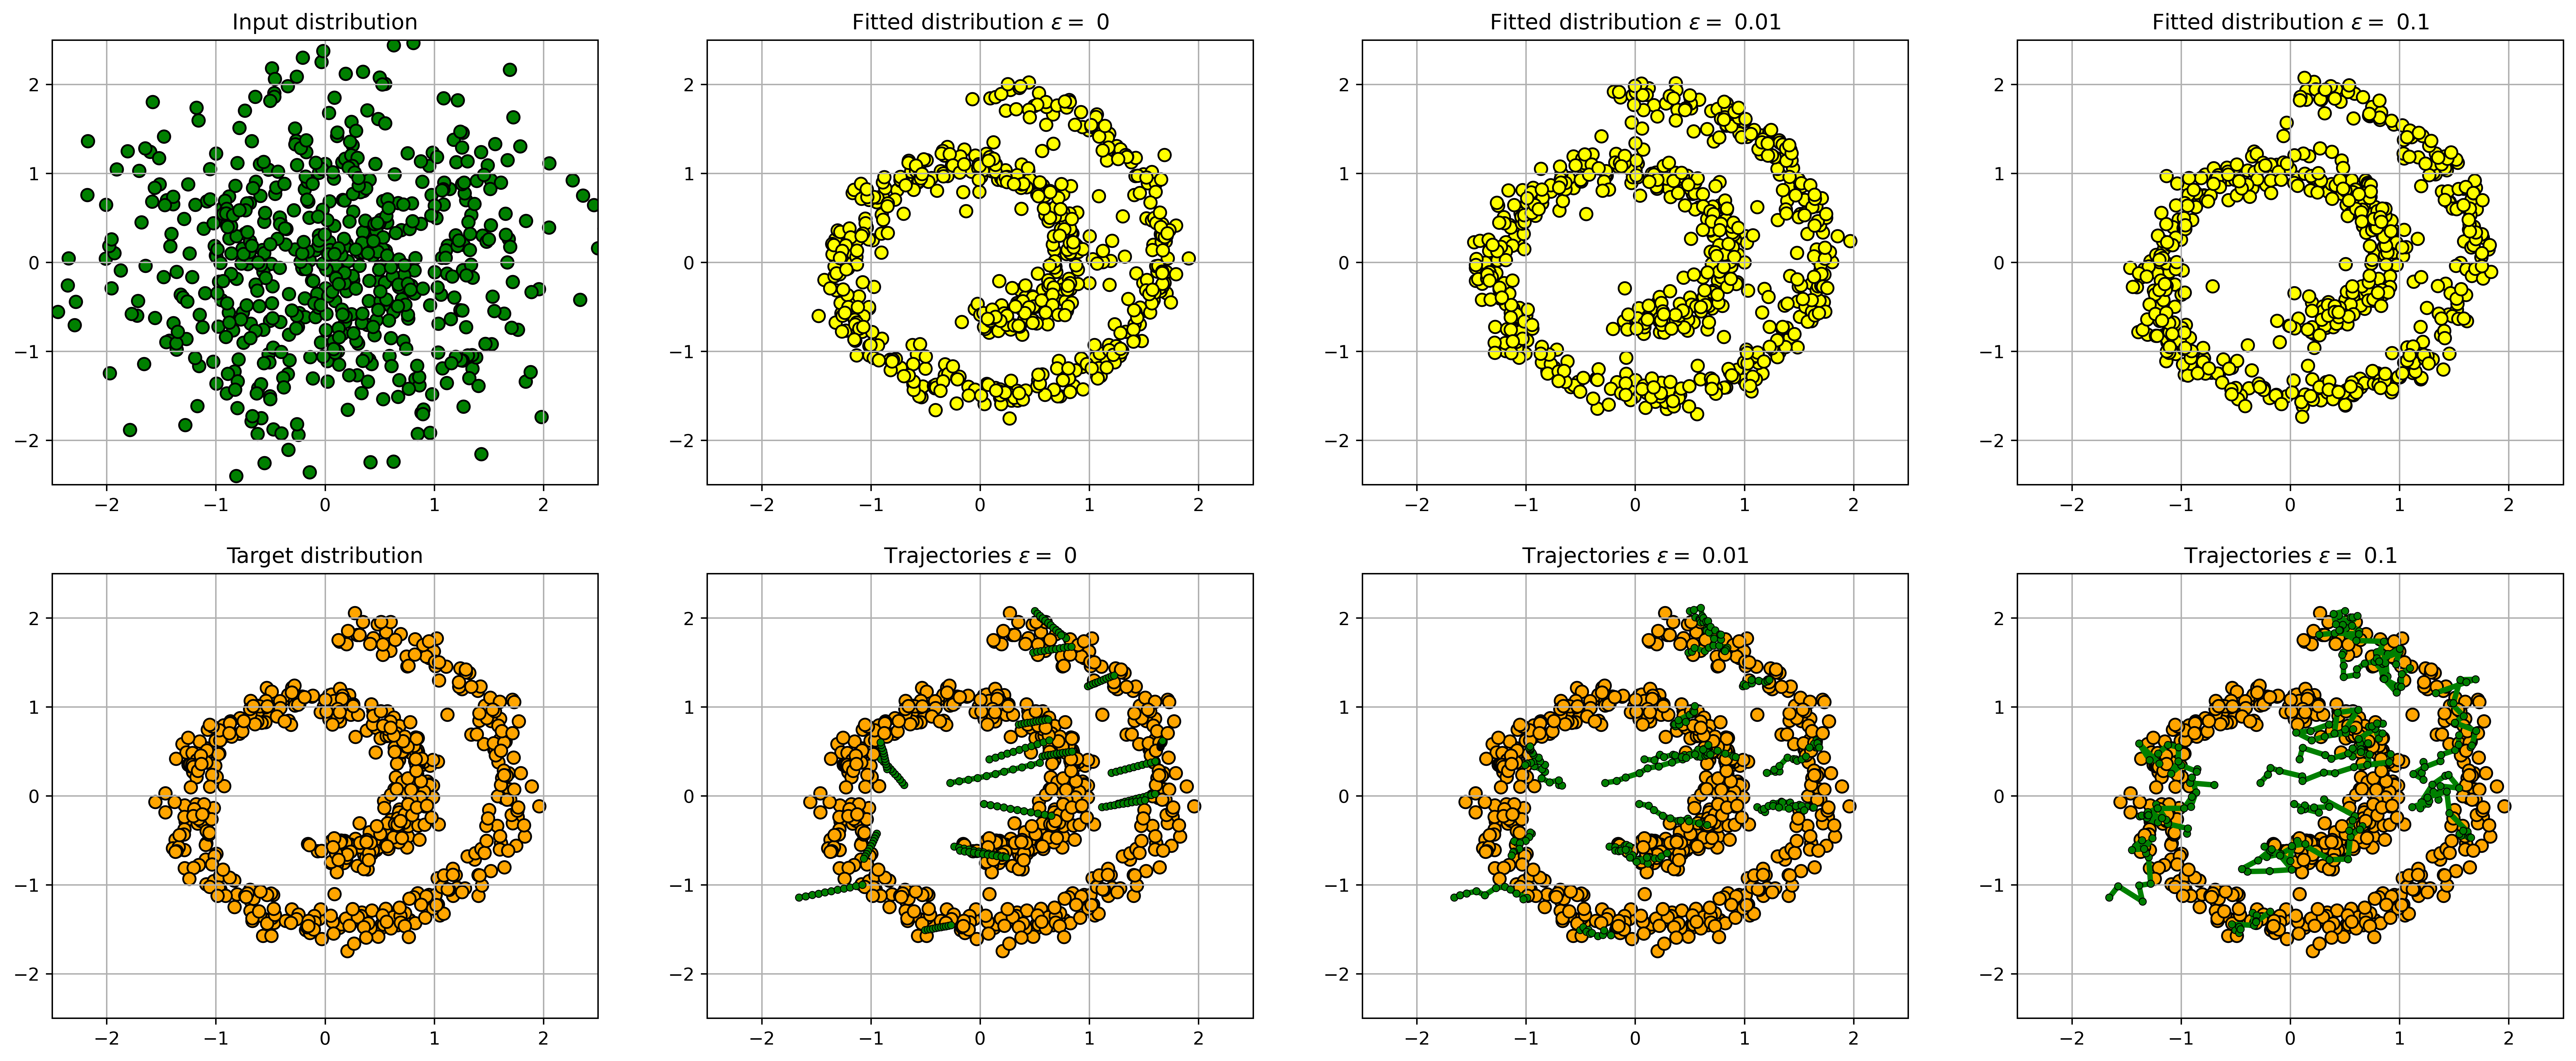

In [6]:
torch.manual_seed(SEED); np.random.seed(SEED)

fig, axes = plt.subplots(2, 4, figsize=(25, 10), dpi=450)
axes[0, 0].scatter(
    original_dataset.numpy()[:, 0], original_dataset.numpy()[:, 1],
    c="g", s=48, edgecolors="black",
)
axes[0, 0].set_title("Input distribution")

axes[1, 0].scatter(
    target_dataset.numpy()[:, 0], target_dataset.numpy()[:, 1],
    c="orange", s=48, edgecolors="black",
)
axes[1, 0].set_title("Target distribution")

for n, (sde, epsilon) in enumerate(zip(sdes, epsilons)):
    n = n+1
    transfered_dataset = map_dataset(sde, original_dataset, plot_n_samples=plot_n_samples)
    axes[0, n].scatter(
        transfered_dataset.numpy()[:, 0], transfered_dataset.numpy()[:, 1],
        c="yellow", s=48, edgecolors="black"
    )
    axes[0, n].set_title("Fitted distribution $\epsilon=$ "+ f"{epsilon}")
    
    tr = sde(original_dataset[:20])[0].detach()
    
    for i in range(20):
        axes[1, n].plot(tr[i, :, 0], tr[i, :, 1], "-o", markeredgecolor="black", 
                            c="green", linewidth=3, markersize=4, markeredgewidth=0.5,)

    axes[1, n].scatter(
        target_dataset.numpy()[:, 0], target_dataset.numpy()[:, 1],
        c="orange", s=48, edgecolors="black", label="target data"
    )
    axes[1, n].set_title("Trajectories $\epsilon=$ "+ f"{epsilon}")


for i in range(8):
    axes[i%2, i//2].grid()
    axes[i%2, i//2].set_xlim([-2.5, 2.5])
    axes[i%2, i//2].set_ylim([-2.5, 2.5])

plt.savefig(f"../pics/{target_data_type}_results.jpg")

### Pictures for the article

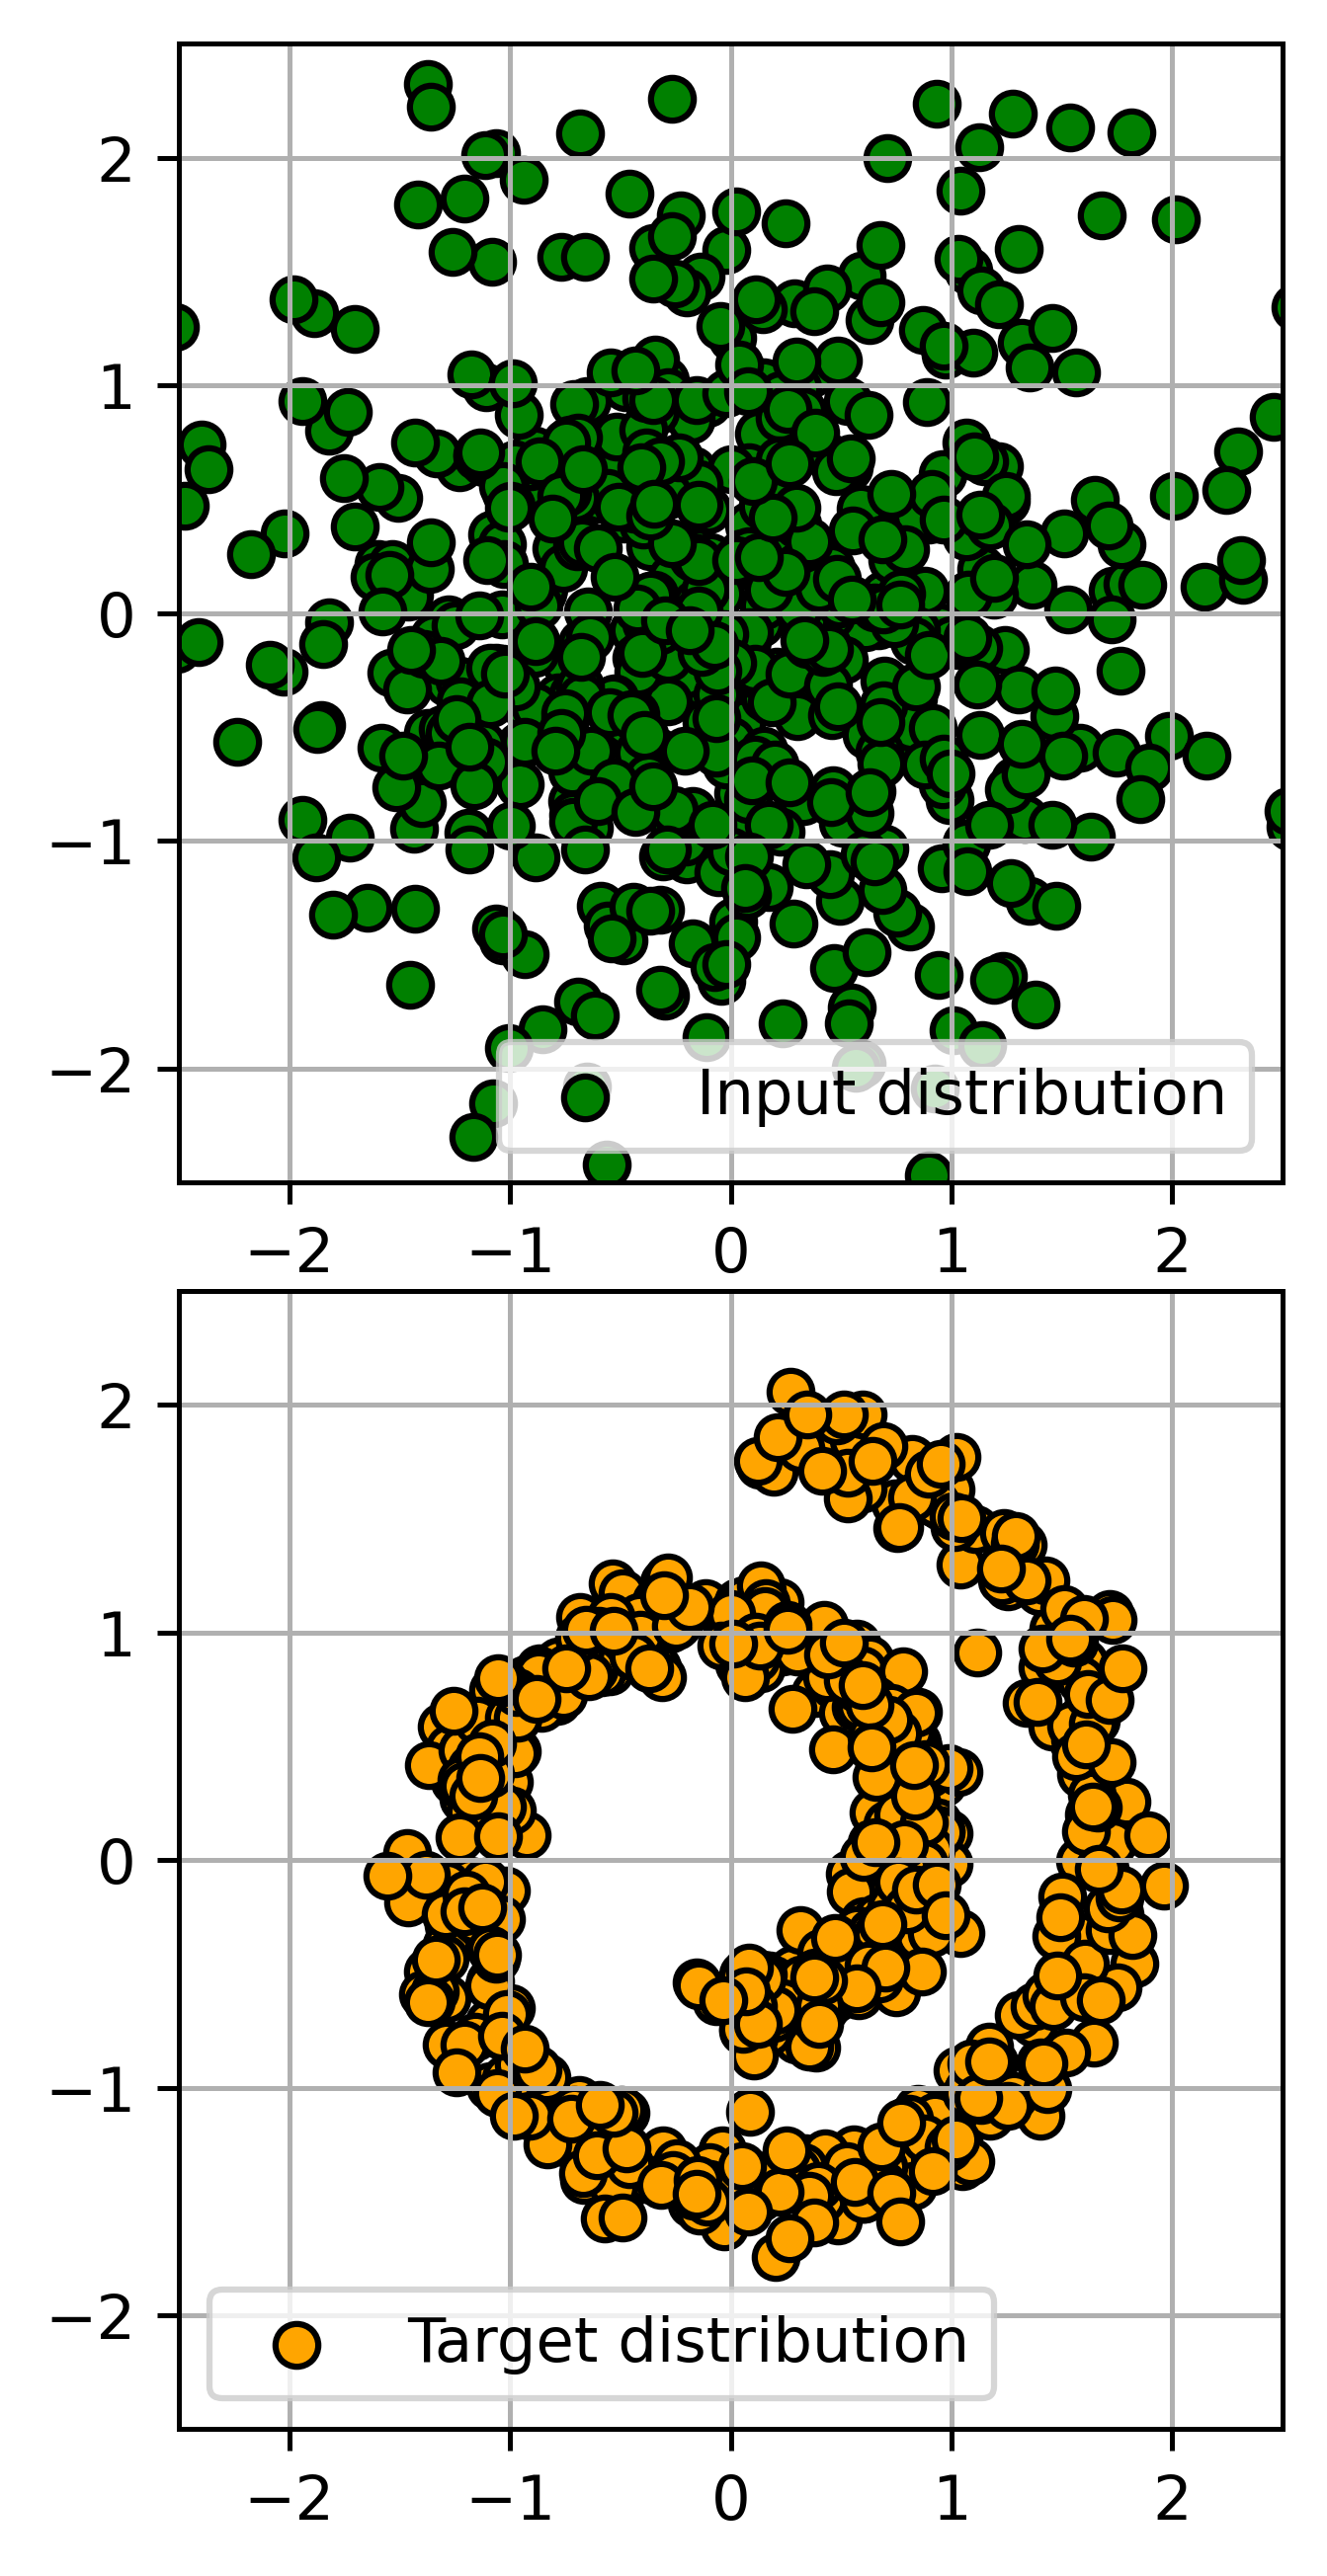

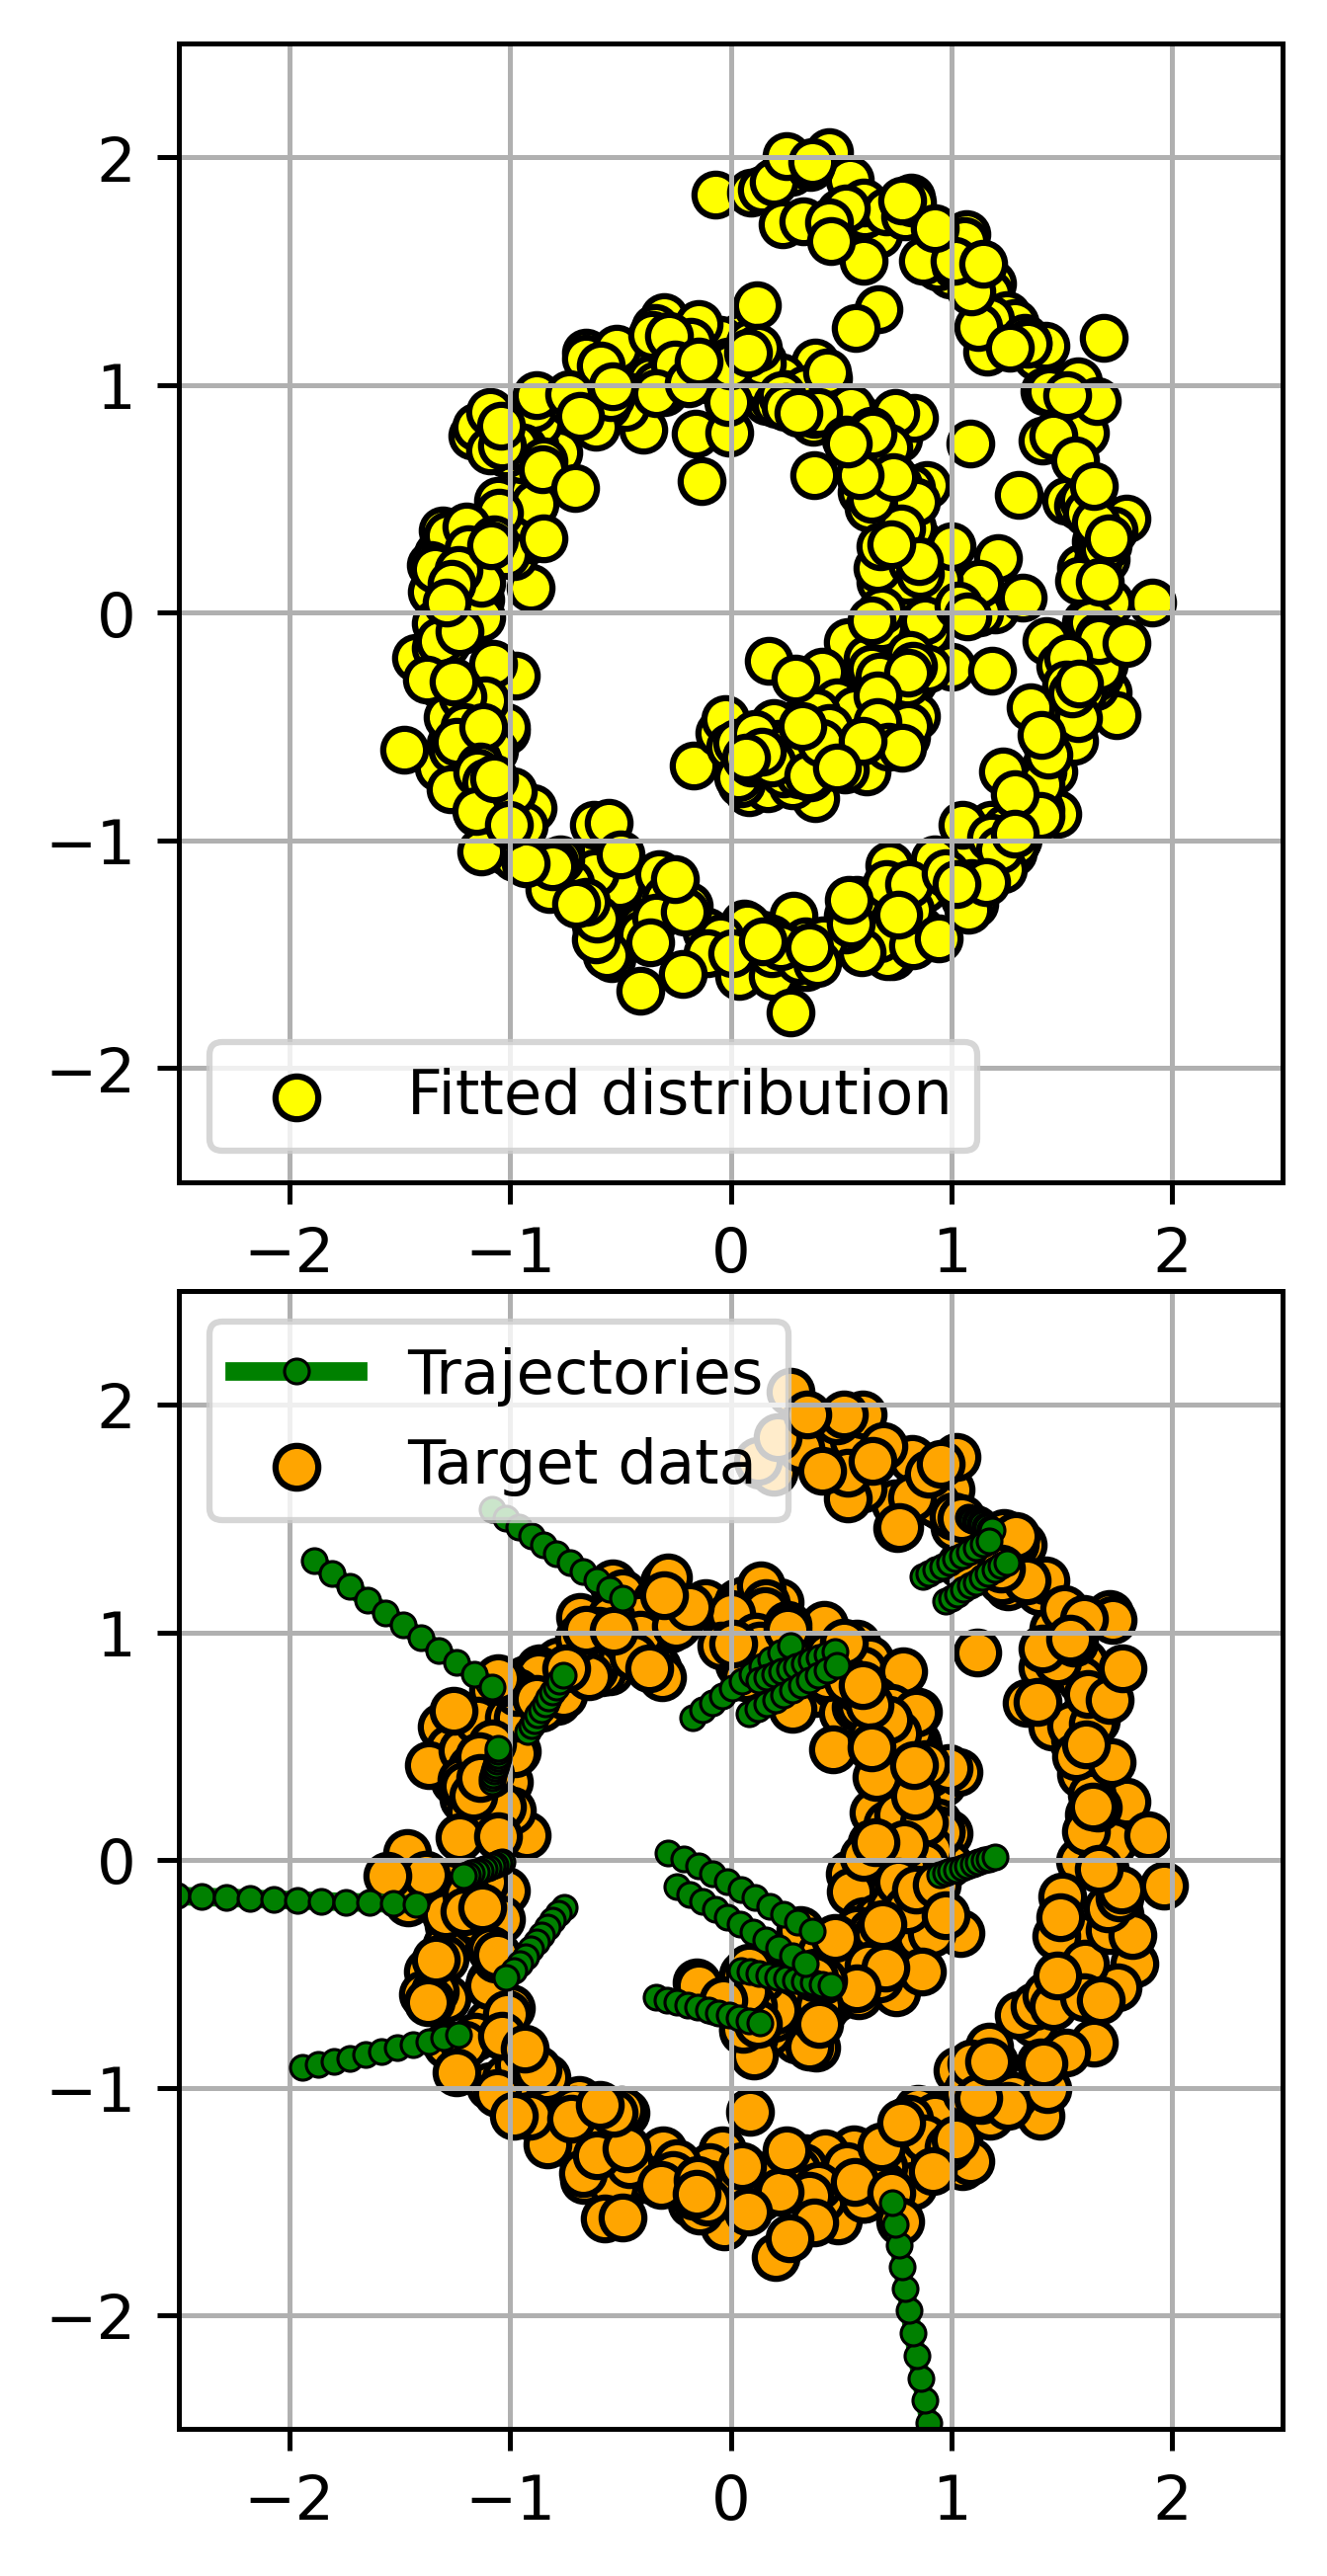

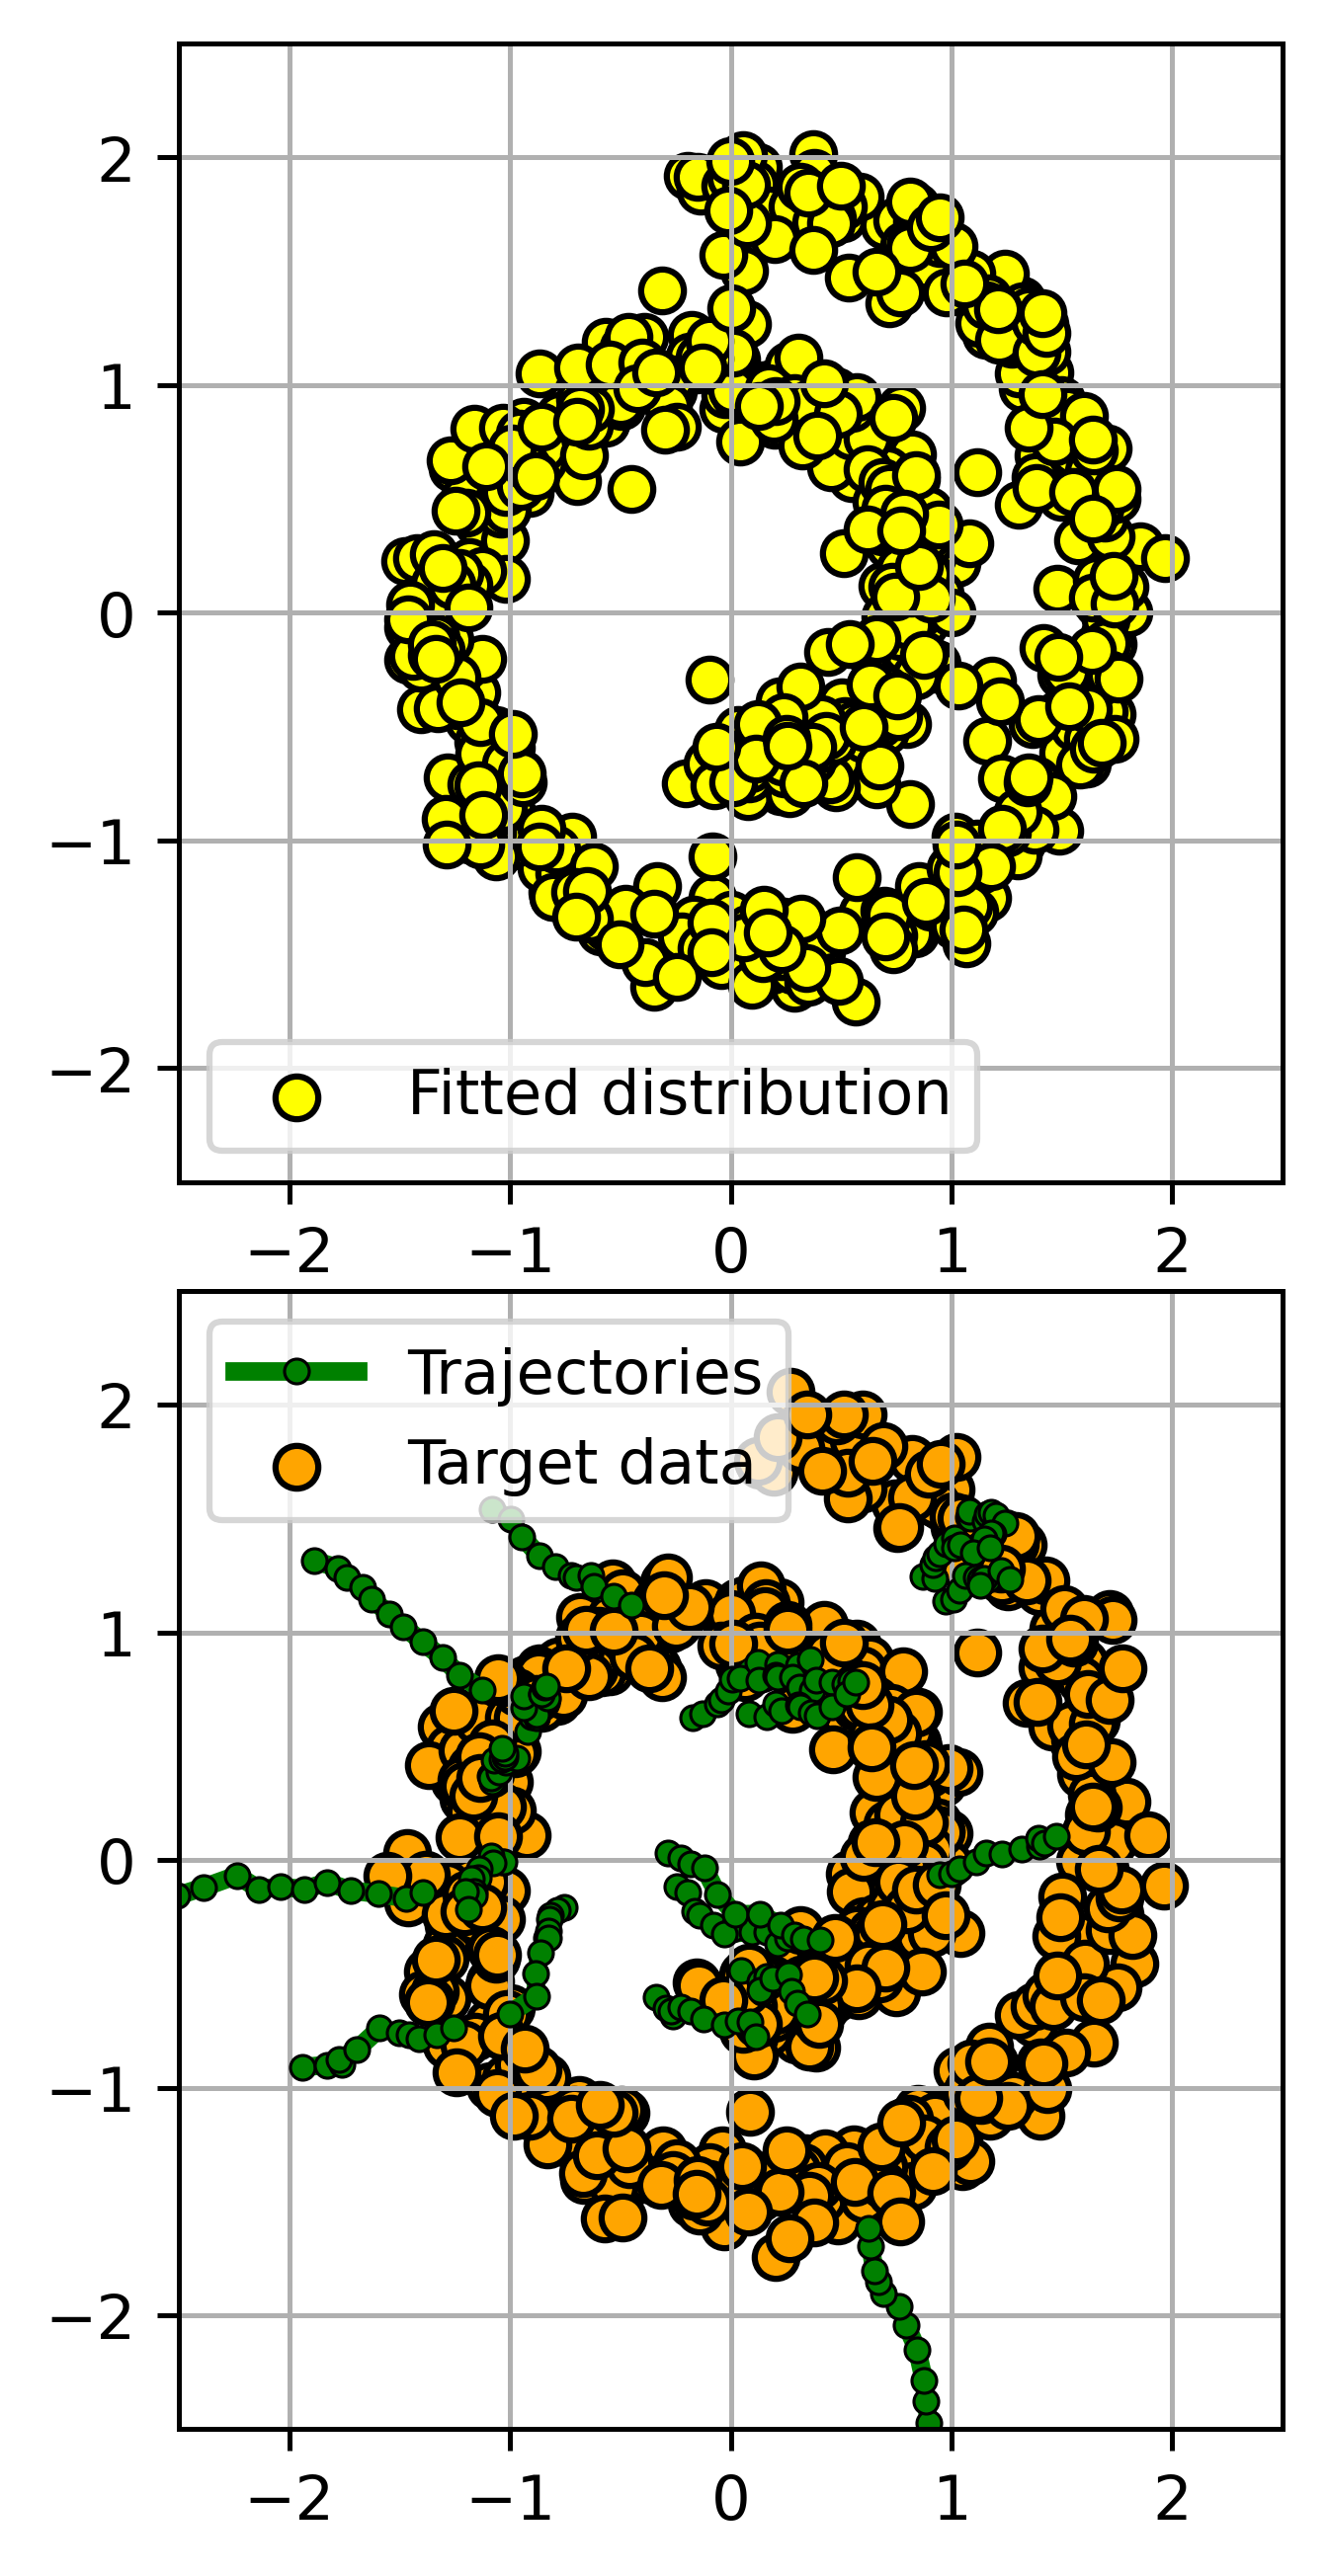

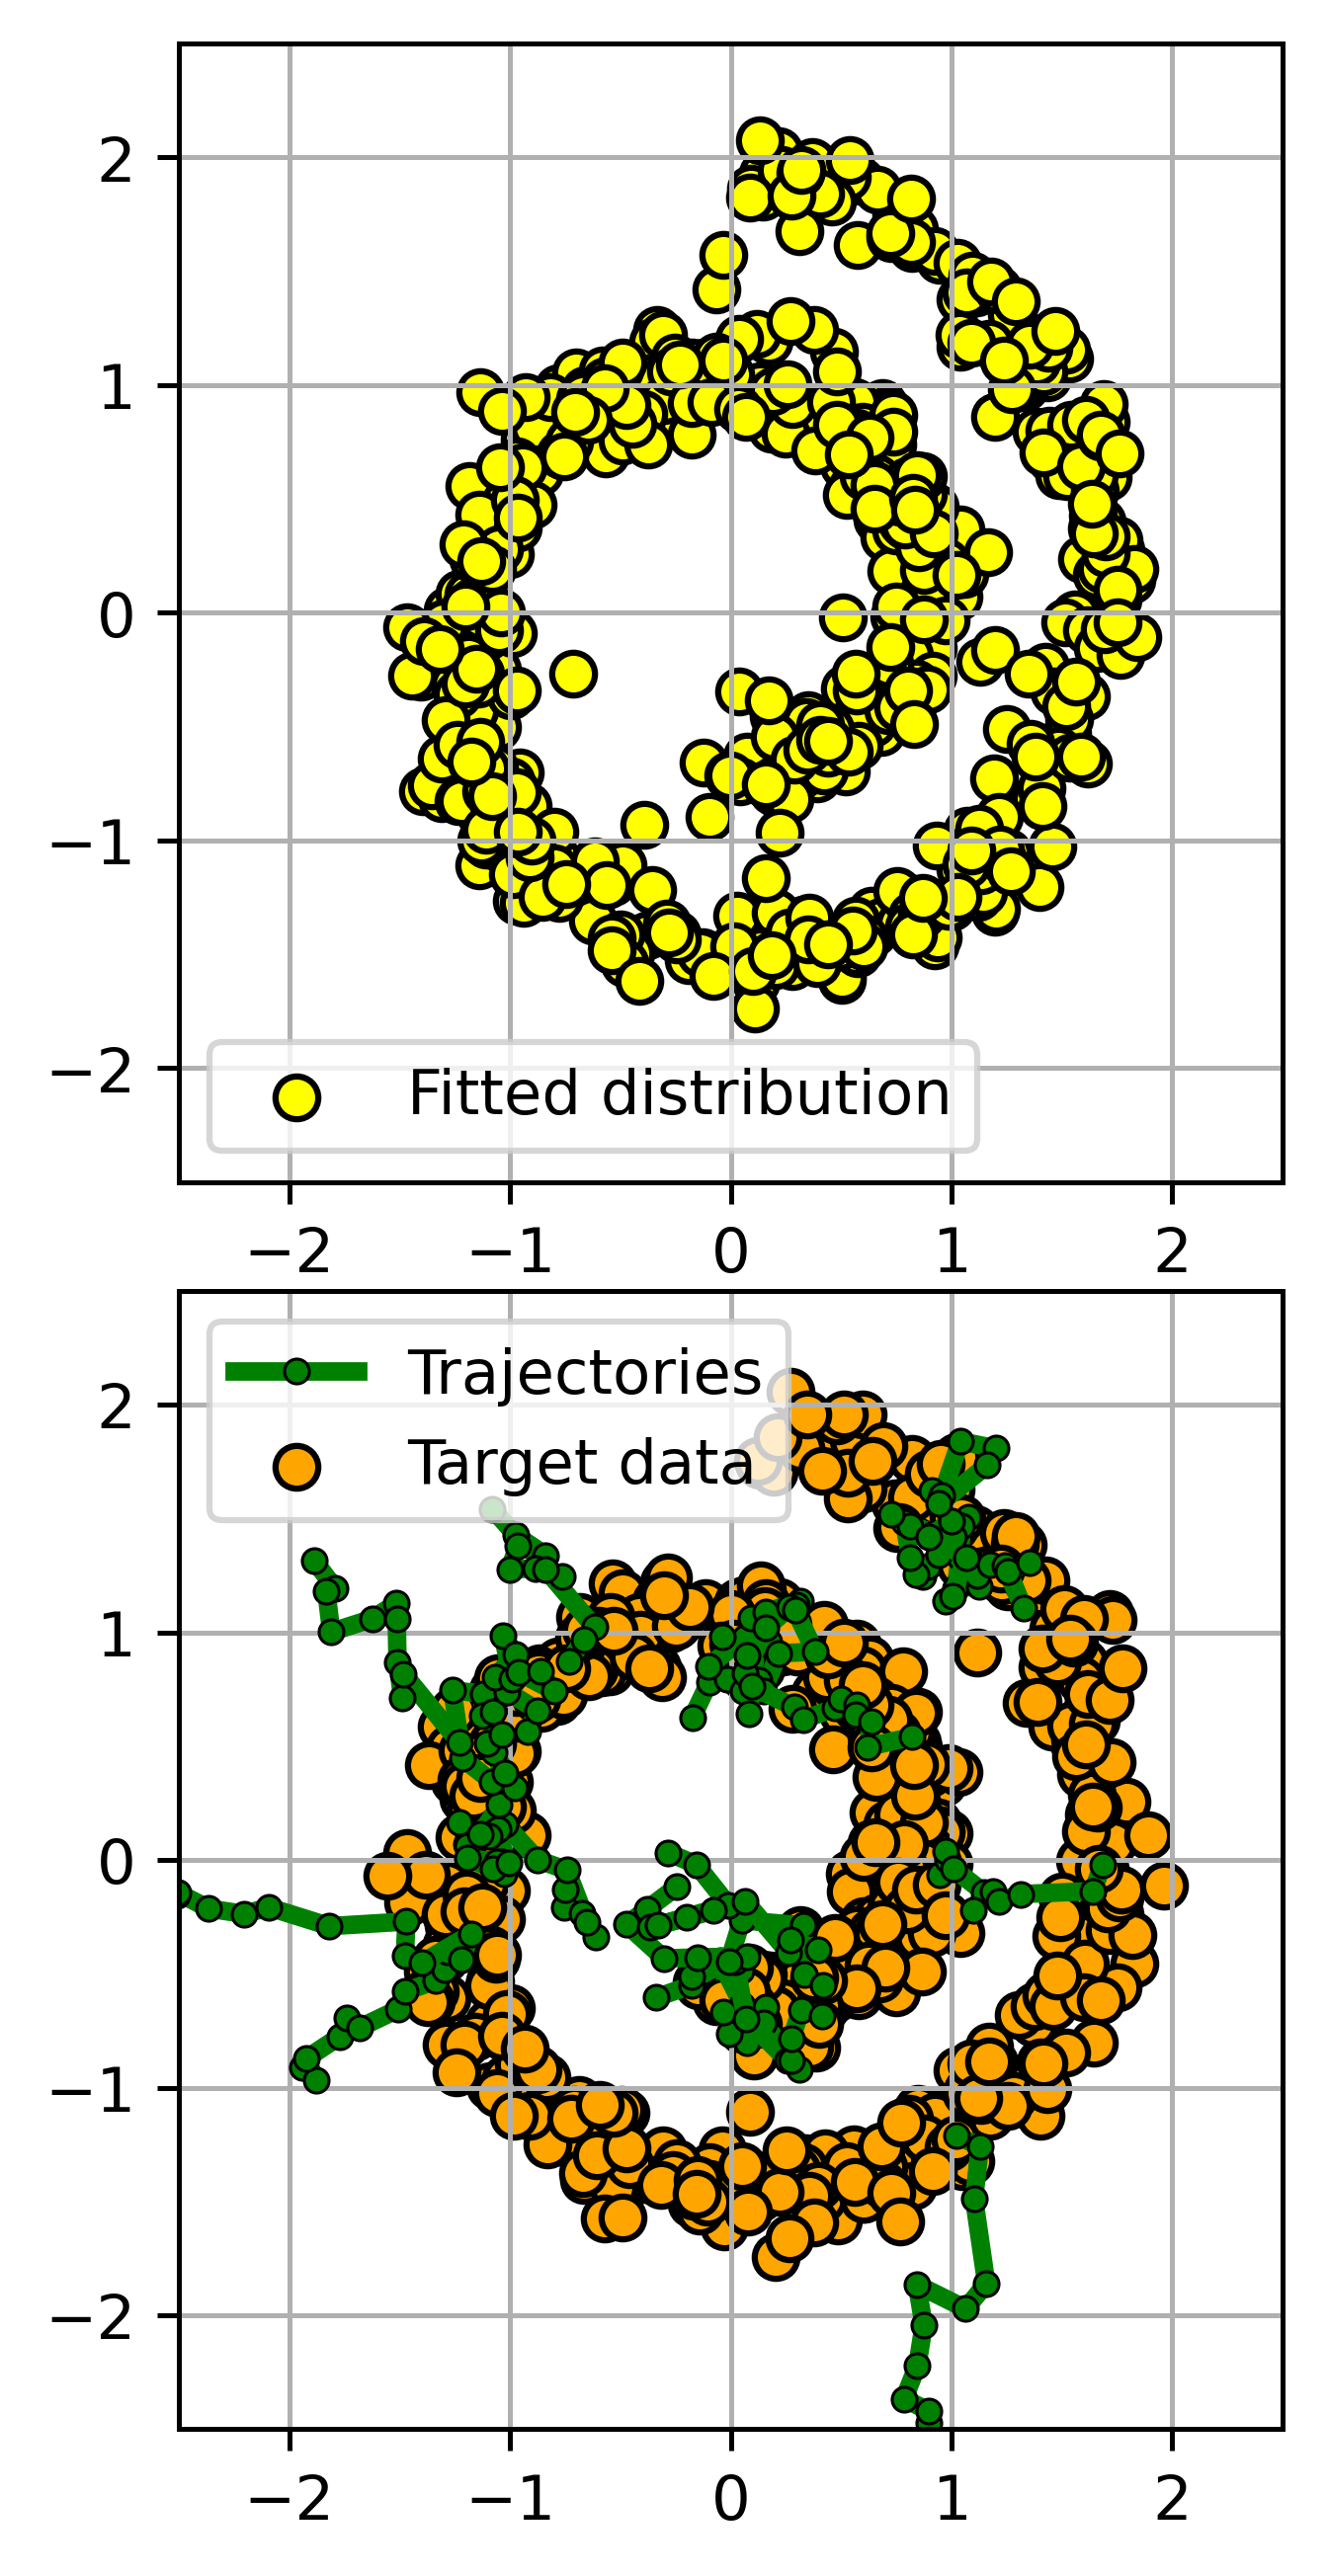

In [69]:
torch.manual_seed(SEED); np.random.seed(SEED)

fig, axes = plt.subplots(2, 1, figsize=(3.125*0.9, 6.25*0.9), dpi=450)
axes[0].scatter(
    original_dataset.numpy()[:, 0], original_dataset.numpy()[:, 1],
    c="g", s=48, edgecolors="black", label = "Input distribution"
)
axes[0].legend()
axes[0].grid()
# axes[0, 0].set_title("Input distribution")

axes[1].scatter(
    target_dataset.numpy()[:, 0], target_dataset.numpy()[:, 1],
    c="orange", s=48, edgecolors="black", label = "Target distribution"
)
axes[1].legend()
axes[1].grid()
fig.tight_layout(pad=0.1)

for i in range(2):
    axes[i%2].set_xlim([-2.5, 2.5])
    axes[i%2].set_ylim([-2.5, 2.5])

plt.savefig(f"../pics/{target_data_type}_results_input_and_target.jpg")

for n, (sde, epsilon) in enumerate(zip(sdes, epsilons)):
    fig, axes = plt.subplots(2, 1, figsize=(3.125*0.9, 6.25*0.9), dpi=450)
#     n = n+1
    transfered_dataset = map_dataset(sde, original_dataset, plot_n_samples=plot_n_samples)

    axes[0].scatter(
        transfered_dataset.numpy()[:, 0], transfered_dataset.numpy()[:, 1],
        c="yellow", s=48, edgecolors="black", label="Fitted distribution"
    )
    axes[0].legend()
    
    tr = sde(original_dataset[:20])[0].detach()
    
    n_traj = 20 if epsilon < 1 else 5
    for i in range(n_traj):
        if i == 0:
            axes[1].plot(tr[i, :, 0], tr[i, :, 1], "-o", markeredgecolor="black", 
                            c="green", linewidth=3, markersize=4, markeredgewidth=0.5,
                            label="Trajectories"
            )

        else:
            axes[1].plot(tr[i, :, 0], tr[i, :, 1], "-o", markeredgecolor="black", 
                            c="green", linewidth=3, markersize=4, markeredgewidth=0.5,
            )
            

    axes[1].scatter(
        target_dataset.numpy()[:, 0], target_dataset.numpy()[:, 1],
        c="orange", s=48, edgecolors="black", label="Target data"
    )
    axes[1].legend()


    for i in range(2):
        axes[i%2].grid()
        axes[i%2].set_xlim([-2.5, 2.5])
        axes[i%2].set_ylim([-2.5, 2.5])

    fig.tight_layout(pad=0.1)

    plt.savefig(f"../pics/{target_data_type}_results_{epsilon}.jpg")